In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.model_selection import RandomizedSearchCV

from pandas.api.types import CategoricalDtype

%matplotlib inline

#### Data Injection & Basic Data Exploratory

In [136]:
df = pd.read_csv('case_study_data.csv')
df.head()

,PRODUCT,SALESYEAR,LIFECYCLE,STATE,RELEASE_YEAR,DISEASE_RESISTANCE,INSECT_RESISTANCE,PROTECTION,DROUGHT_TOLERANCE,BRITTLE_STALK,PLANT_HEIGHT,RELATIVE_MATURITY,UNITS
0,P14,2021,ESTABLISHED,Texas,2013,0,0,1,5.0,3.0,1.0,3,0.0
1,P27,2021,INTRODUCTION,Texas,2019,0,0,1,3.0,4.0,2.0,3,0.2
2,P54,2021,ESTABLISHED,Texas,2018,0,1,1,5.0,4.0,1.0,4,4.6
3,P67,2021,EXPANSION,Texas,2014,0,1,1,4.0,5.0,3.0,4,9.7
4,P110,2021,EXPANSION,Texas,2018,0,0,1,3.0,4.0,3.0,4,0.2


In [3]:
print(df.info())
print('-------------')
print(df.describe())
print('-------------')
print(df.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2166 entries, 0 to 2165
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   PRODUCT             2166 non-null   object 
 1   SALESYEAR           2166 non-null   int64  
 2   LIFECYCLE           2166 non-null   object 
 3   STATE               2166 non-null   object 
 4   RELEASE_YEAR        2166 non-null   int64  
 5   DISEASE_RESISTANCE  2166 non-null   int64  
 6   INSECT_RESISTANCE   2166 non-null   int64  
 7   PROTECTION          2166 non-null   int64  
 8   DROUGHT_TOLERANCE   2117 non-null   float64
 9   BRITTLE_STALK       2143 non-null   float64
 10  PLANT_HEIGHT        2143 non-null   float64
 11  RELATIVE_MATURITY   2166 non-null   int64  
 12  UNITS               2166 non-null   float64
dtypes: float64(4), int64(6), object(3)
memory usage: 220.1+ KB
None
-------------
         SALESYEAR  RELEASE_YEAR  DISEASE_RESISTANCE  INSECT_RESISTANCE  \


In [4]:
print(df['PRODUCT'].value_counts())

P127    30
P156    26
P82     26
P201    26
P155    26
        ..
P280     1
P200     1
P304     1
P176     1
P100     1
Name: PRODUCT, Length: 338, dtype: int64


#### EDA

In [137]:
# Categorical/object columns
df['PRODUCT'] = df['PRODUCT'].astype('category')
df['LIFECYCLE'] = df['LIFECYCLE'].astype('category')
df['STATE'] = df['STATE'].astype('category')

# Binary features 
binary_cols = ['DISEASE_RESISTANCE', 'INSECT_RESISTANCE', 'PROTECTION']
df[binary_cols] = df[binary_cols].astype('category')  

# Ordinal features
ordinal_cols = ['DROUGHT_TOLERANCE', 'BRITTLE_STALK', 'PLANT_HEIGHT', 'RELATIVE_MATURITY']
ordered_cat = CategoricalDtype(categories=[1, 2, 3, 4, 5], ordered=True)
for col in ordinal_cols:
    df[col] = df[col].astype('Int64')        
    df[col] = df[col].astype(ordered_cat)

# Year features 
# df['SALESYEAR'] = pd.to_datetime(df['SALESYEAR'], format='%Y').dt.year
# df['RELEASE_YEAR'] = pd.to_datetime(df['RELEASE_YEAR'], format='%Y').dt.year

# Target variable
df['UNITS'] = df['UNITS'].astype('float32')

In [138]:
# FOR DEBUG ONLY: check for duplicated rows with only 'UNITS' differing
group_cols = [col for col in df.columns if col != 'UNITS']
dups = df.duplicated(subset=group_cols, keep=False)
test = df[dups & (df['PRODUCT'] == 'P122')]
test = test.groupby(['PRODUCT', 'STATE', 'SALESYEAR'], as_index=False).agg(agg_dict)
test[test['UNITS'] != 0]

,UNITS,PRODUCT,SALESYEAR,LIFECYCLE,STATE,RELEASE_YEAR,DISEASE_RESISTANCE,INSECT_RESISTANCE,PROTECTION,DROUGHT_TOLERANCE,BRITTLE_STALK,PLANT_HEIGHT,RELATIVE_MATURITY
131,2.6,P122,2021.0,ESTABLISHED,Illinois,2018.0,0,0,1,NaN,NaN,NaN,4


In [139]:
# Grouping by PRODUCT, STATE, and SALESYEAR to sum UNITS
agg_dict = {'UNITS': 'sum'}
for col in df.columns:
    if col != 'UNITS':
        agg_dict[col] = 'first'

df = df.groupby(['PRODUCT', 'STATE', 'SALESYEAR'], as_index=False).agg(agg_dict)
df = df[~df['PRODUCT'].isnull()]

df = df[df['UNITS']<=100]
print(df.shape)

(1741, 13)


Skewness: 4.4048357
Kurtosis: 23.455776


divide by zero encountered in log


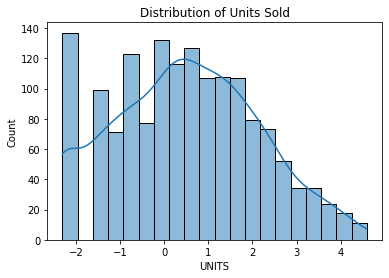

<Figure size 720x576 with 0 Axes>

In [110]:
# Visualize target distribution
sns.histplot(np.log(df['UNITS']), bins=20, kde=True) #log(0) = -inf
plt.title("Distribution of Units Sold")
plt.figure(figsize=(10, 8))

print("Skewness:", df['UNITS'].skew())
print("Kurtosis:", df['UNITS'].kurt())

Text(0.5, 1.0, 'Correlation Matrix')

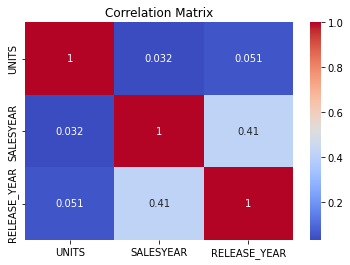

In [101]:
# Correlation heatmap
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")

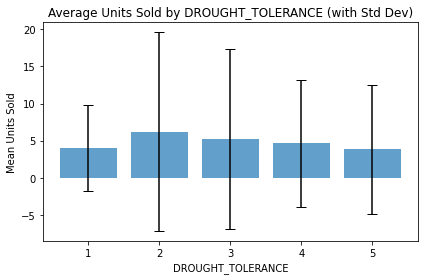

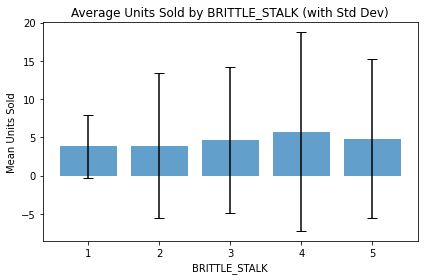

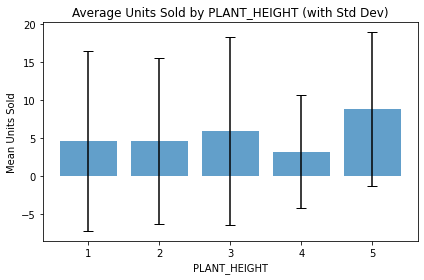

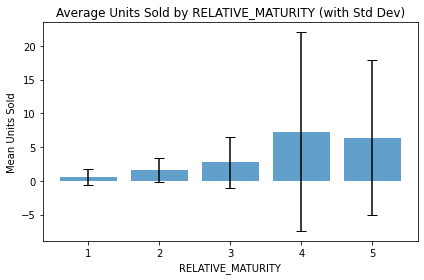

In [111]:
# Barplot of mean +- std for ordinal features
# Intepretation of the bar plots:
# - Bar height (top edge) represents the average number of units sold for each category of the ordinal feature; lower edge anchors at 0.
#   - So higher bars indicate higher average sales.
# - Error bars represent one standard deviation above and below the mean.
for col in ordinal_cols:
    summary = df.groupby(col)['UNITS'].agg(['mean', 'std']).reset_index()
    
    plt.bar(summary[col], summary['mean'], yerr=summary['std'], capsize=5, alpha=0.7)
    plt.xlabel(col)
    plt.ylabel('Mean Units Sold')
    plt.title(f'Average Units Sold by {col} (with Std Dev)')
    plt.tight_layout()
    plt.show()


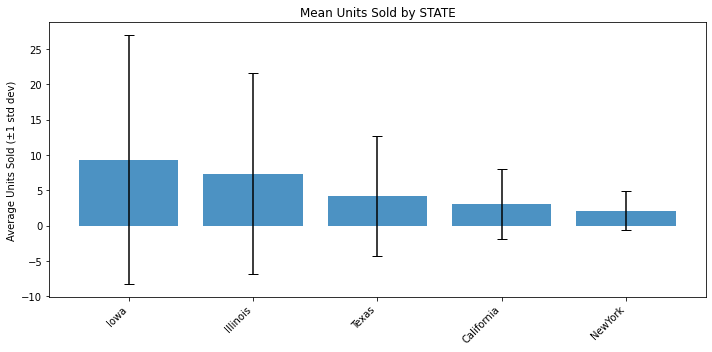

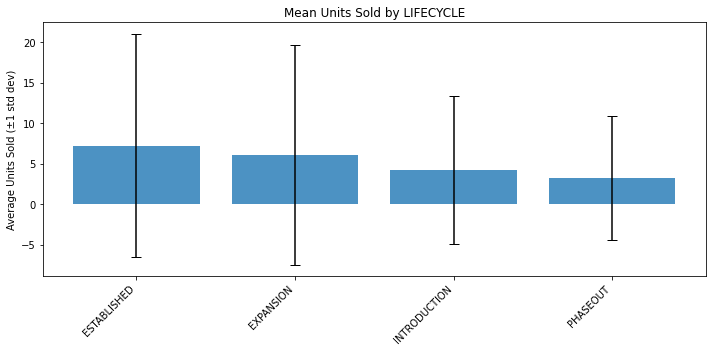

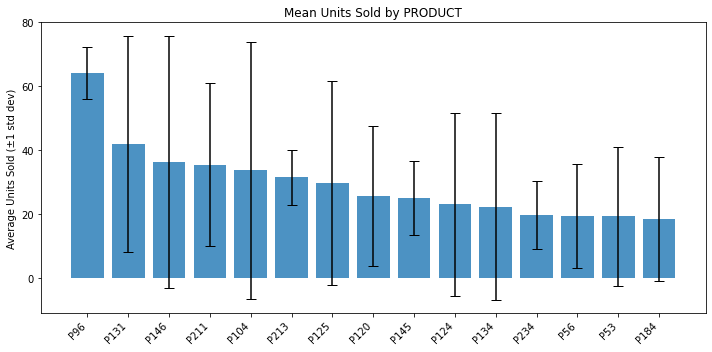

In [112]:
cat_cols = ['STATE', 'LIFECYCLE', 'PRODUCT']

for col in cat_cols:
    summary = df.groupby(col)['UNITS'].agg(['mean', 'std', 'count']).reset_index()
    summary = summary.sort_values('mean', ascending=False).head(15)  # Top 15 if too many

    plt.figure(figsize=(10, 5))
    plt.bar(summary[col], summary['mean'], yerr=summary['std'], capsize=5, alpha=0.8)
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Average Units Sold (±1 std dev)')
    plt.title(f'Mean Units Sold by {col}')
    plt.tight_layout()
    plt.show()

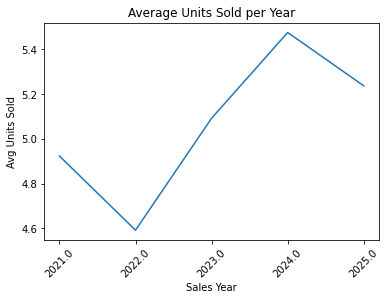

In [113]:
yearly = df.groupby('SALESYEAR')['UNITS'].mean().reset_index()
sns.lineplot(x='SALESYEAR', y='UNITS', data=yearly)
plt.xticks(ticks=yearly['SALESYEAR'], labels=yearly['SALESYEAR'], rotation=45)
plt.title('Average Units Sold per Year')
plt.xlabel('Sales Year')
plt.ylabel('Avg Units Sold')
plt.show()

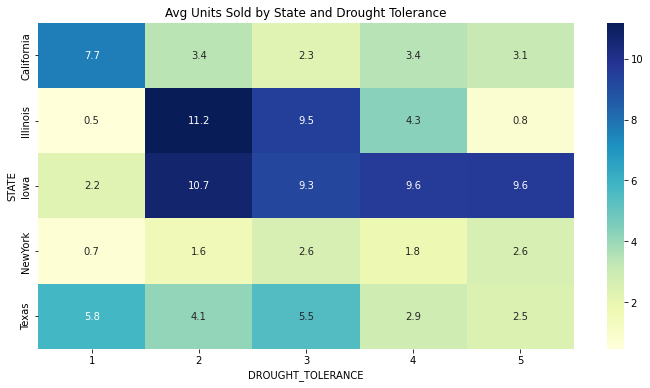

In [114]:
# Aggregated mean units
pivot = df.pivot_table(values='UNITS', index='STATE', columns='DROUGHT_TOLERANCE', aggfunc='mean')
plt.figure(figsize=(12, 6))
sns.heatmap(pivot, annot=True, cmap='YlGnBu', fmt=".1f")
plt.title('Avg Units Sold by State and Drought Tolerance')
plt.show()

#### Data Enrichment & FE

In [140]:
np.random.seed(42)  

# Define base values by state
state_base_drought = {
    'Texas': 1.6,
    'Iowa': 1.2,
    'Illinois': 1.1,
    'NewYork': 1.0,
    'California': 1.5
}
state_farm_size = {
    'Texas': 600,
    'Iowa': 450,
    'Illinois': 470,
    'NewYork': 300,
    'California': 400
}

# 1. Simulated drought index (state base + noise)
df['DROUGHT_INDEX'] = df['STATE'].map(state_base_drought).fillna(1.0).astype(float)
df['DROUGHT_INDEX'] += np.random.normal(loc=0, scale=0.2, size=len(df))

# 2. Simulated competitor pressure (0–1 scale)
df['COMPETITOR_PRESSURE'] = np.random.uniform(0, 1, size=len(df))

# 3. Simulated marketing campaign exposure (binary)
df['MARKETING_CAMPAIGN'] = np.random.binomial(1, 0.3, size=len(df))

# 4. Simulated average farm size (state base + noise)
df['AVG_FARM_SIZE'] = df['STATE'].map(state_farm_size).fillna(400).astype(float)
df['AVG_FARM_SIZE'] += np.random.normal(loc=0, scale=30, size=len(df))

# 5. Simulated weather volatility index (0–1, beta distribution)
df['WEATHER_VOLATILITY'] = np.random.beta(a=2, b=5, size=len(df))

# 6. Simulated disease outbreak risk (0–1, beta)
df['DISEASE_OUTBREAK_RISK'] = np.random.beta(a=1.5, b=3, size=len(df))

print(df[['STATE', 'DROUGHT_INDEX', 'COMPETITOR_PRESSURE', 'MARKETING_CAMPAIGN',
          'AVG_FARM_SIZE', 'WEATHER_VOLATILITY', 'DISEASE_OUTBREAK_RISK']].describe(include='all'))

             STATE  DROUGHT_INDEX  COMPETITOR_PRESSURE  MARKETING_CAMPAIGN  \
count         1741    1741.000000          1741.000000         1741.000000   
unique           5            NaN                  NaN                 NaN   
top     California            NaN                  NaN                 NaN   
freq           527            NaN                  NaN                 NaN   
mean           NaN       1.280662             0.495076            0.283171   
std            NaN       0.301476             0.288289            0.450668   
min            NaN       0.415730             0.000012            0.000000   
25%            NaN       1.047348             0.251001            0.000000   
50%            NaN       1.266784             0.491096            0.000000   
75%            NaN       1.506165             0.742253            1.000000   
max            NaN       2.370546             0.999558            1.000000   

        AVG_FARM_SIZE  WEATHER_VOLATILITY  DISEASE_OUTBREAK_RIS

In [141]:
df['PRODUCT_AGE'] = df['SALESYEAR'] - df['RELEASE_YEAR']

df = df.sort_values(by=['PRODUCT', 'STATE', 'SALESYEAR'])
df['UNITS_LAG1'] = df.groupby(['PRODUCT', 'STATE'])['UNITS'].shift(1)
# df['YOY_CHANGE'] = df['UNITS'] / df['UNITS_LAG1'] - 1

# Many rows will have NaN in 'UNITS_LAG1' because they are the first year for that product-state combination.
# I dropped na here since I found out that model performs better with data having lagged feature
df = df.dropna(subset=['UNITS_LAG1'])

In [142]:
df

,UNITS,PRODUCT,SALESYEAR,LIFECYCLE,STATE,RELEASE_YEAR,DISEASE_RESISTANCE,INSECT_RESISTANCE,PROTECTION,DROUGHT_TOLERANCE,...,PLANT_HEIGHT,RELATIVE_MATURITY,DROUGHT_INDEX,COMPETITOR_PRESSURE,MARKETING_CAMPAIGN,AVG_FARM_SIZE,WEATHER_VOLATILITY,DISEASE_OUTBREAK_RISK,PRODUCT_AGE,UNITS_LAG1
1,23.000000,P1,2022.0,EXPANSION,California,2006.0,0,0,0,1,...,5,4,1.472347,0.034670,0,387.477089,0.145320,0.051283,16.0,23.500000
2,6.100000,P1,2023.0,EXPANSION,California,2006.0,0,0,0,1,...,5,4,1.629538,0.582807,0,410.321618,0.215200,0.695567,17.0,23.000000
3,20.299999,P1,2024.0,EXPANSION,California,2006.0,0,0,0,1,...,5,4,1.804606,0.995438,1,410.450252,0.168135,0.224874,18.0,6.100000
4,12.800000,P1,2025.0,PHASEOUT,California,2006.0,0,0,0,1,...,5,4,1.453169,0.855696,1,373.065098,0.358652,0.557191,19.0,20.299999
16,1.400000,P1,2022.0,EXPANSION,NewYork,2006.0,0,0,0,1,...,5,4,1.315843,0.063641,0,332.229990,0.198075,0.335487,16.0,1.300000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8359,58.400002,P96,2025.0,ESTABLISHED,Illinois,2021.0,0,0,1,2,...,3,4,1.055307,0.973800,1,484.933649,0.216035,0.009397,4.0,69.800003
8384,1.100000,P97,2025.0,PHASEOUT,Illinois,2022.0,0,0,1,2,...,3,4,1.096116,0.275239,1,489.269037,0.354360,0.299852,3.0,29.299999
8389,0.600000,P97,2025.0,PHASEOUT,Iowa,2022.0,0,0,1,2,...,3,4,1.359988,0.271492,0,480.198196,0.271241,0.098435,3.0,25.000000
8426,0.800000,P99,2022.0,PHASEOUT,California,2017.0,0,0,1,3,...,2,4,1.286439,0.549869,0,479.136453,0.107073,0.430853,5.0,3.700000


#### Preprocessing + Training

In [143]:
cat_cols = ['STATE', 'LIFECYCLE', 'PRODUCT']
numeric_cols = ['PRODUCT_AGE', 'UNITS_LAG1']#, 'YOY_CHANGE']
all_features = cat_cols + binary_cols + ordinal_cols + numeric_cols
target = 'UNITS'

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))
])

preprocessor = ColumnTransformer(transformers=[
    ('cat', categorical_transformer, cat_cols),
    ('num', numeric_transformer, binary_cols + ordinal_cols + numeric_cols)
])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(objective='reg:squarederror', random_state=42, tree_method='hist')) 
])

In [144]:
cutoff_year = df['SALESYEAR'].max() - 1
X = df[all_features]
y = df[target]

X_train = X[df['SALESYEAR'] <= cutoff_year]
y_train = y[df['SALESYEAR'] <= cutoff_year]
X_test = X[df['SALESYEAR'] > cutoff_year]
y_test = y[df['SALESYEAR'] > cutoff_year]

# Hyperparam tuning
param_distributions = {
    'regressor__n_estimators': [100, 200, 300, 500],
    'regressor__max_depth': [3, 4, 5, 6, 8, 10],
    'regressor__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'regressor__subsample': [0.6, 0.8, 1.0],
    'regressor__colsample_bytree': [0.6, 0.8, 1.0],
    'regressor__min_child_weight': [1, 3, 5, 10],
    'regressor__gamma': [0, 0.25, 0.5, 1]
}

from sklearn.model_selection import RandomizedSearchCV

random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    n_iter=30,                  # Number of combinations to try
    cv=3,                       # 3-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1,                  # Use all available CPUs
    scoring='neg_root_mean_squared_error'
)

random_search.fit(X_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('cat',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('encoder',
                                                                                                OneHotEncoder(handle_unknown='ignore',
                                                                                                              sparse=False))]),
                                                                               ['STATE',
                                                                                'LIFECYCLE',
                                                                                'PRODUCT']),
                                                                              ('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer())]),
                                                                               ['DISEASE_RESISTANCE',
                                                                                'IN...
                   param_distributions={'regressor__colsample_bytree': [0.6,
                                                                        0.8,
                                                                        1.0],
                                        'regressor__gamma': [0, 0.25, 0.5, 1],
                                        'regressor__learning_rate': [0.01, 0.05,
                                                                     0.1, 0.2],
                                        'regressor__max_depth': [3, 4, 5, 6, 8,
                                                                 10],
                                        'regressor__min_child_weight': [1, 3, 5,
                                                                        10],
                                        'regressor__n_estimators': [100, 200,
                                                                    300, 500],
                                        'regressor__subsample': [0.6, 0.8,
                                                                 1.0]},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=2)

In [148]:

print("Best parameters:", random_search.best_params_)
print("Best CV score (RMSE):", -random_search.best_score_)
best_model = random_search.best_estimator_

# pipeline.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
y_pred_clipped = np.clip(y_pred, 0, 100)

# Evaluate
print("Model Performance on Future-Year Test Set:")
print(f"RMSE: {mean_squared_error(y_test, y_pred, squared=False):.2f}")
print(f"MAE:  {mean_absolute_error(y_test, y_pred):.2f}")
print(f"R²:   {r2_score(y_test, y_pred):.2f}")

Best parameters: {'regressor__subsample': 0.8, 'regressor__n_estimators': 500, 'regressor__min_child_weight': 1, 'regressor__max_depth': 5, 'regressor__learning_rate': 0.2, 'regressor__gamma': 1, 'regressor__colsample_bytree': 0.6}
Best CV score (RMSE): 6.204181512196858
Model Performance on Future-Year Test Set:
RMSE: 7.45
MAE:  3.39
R²:   0.65


In [146]:
# Hit rate as a metric
def hit_rate(y_true, y_pred, tolerance=0.05):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    # Avoid division by zero
    mask = y_true != 0
    hits = np.abs(y_pred[mask] - y_true[mask]) <= (tolerance * np.abs(y_true[mask]))
    return hits.mean() if len(hits) > 0 else np.nan

# Example usage:
hr_5 = hit_rate(y_test, y_pred, tolerance=0.5)
hr_10 = hit_rate(y_test, y_pred, tolerance=0.10)

print(f"Hit Rate @50%:  {hr_5:.2%}")
print(f"Hit Rate @10%: {hr_10:.2%}")

# Hit rate is low due to around 7/10 of data has targets <= 5.

Hit Rate @50%:  37.66%
Hit Rate @10%: 8.37%


In [147]:
df_eva = pd.DataFrame({'y_true': y_test, 'y_pred': y_pred})

bins = [-0.01, 10, 20, 100]
labels = ['≤10', '11–20', '>20']
df_eva['target_bin'] = pd.cut(df_eva['y_true'], bins=bins, labels=labels, include_lowest=True, right=True, ordered=True)
df_eva['target_bin'] = pd.Categorical(df_eva['target_bin'], categories=labels, ordered=True)

# for bin_label in labels:
#     group = df[df['target_bin'] == bin_label]
#     hr = hit_rate(group['y_true'], group['y_pred'], tolerance=0.30)
#     print(f"Hit Rate @20% for {bin_label}: {hr:.2%} (N={len(group)})")
print(f"{'Bin':<7} {'N':<5} {'HitRate@30%':<12} {'MAE':<8}")
print("-" * 35)
for bin_label in labels:
    group = df_eva[df_eva['target_bin'] == bin_label]
    N = len(group)
    if N > 0:
        hr = hit_rate(group['y_true'], group['y_pred'], tolerance=0.30)
        mae = mean_absolute_error(group['y_true'], group['y_pred'])
        print(f"{bin_label:<7} {N:<5} {hr:.2%}      {mae:.2f}")
    else:
        print(f"{bin_label:<7} 0     N/A         N/A")

Bin     N     HitRate@30%  MAE     
-----------------------------------
≤10     223   17.65%      1.83
11–20   20    35.00%      8.10
>20     15    46.67%      20.35


In [149]:
# Show a sample of results
results = X_test.copy()
results['Actual_UNITS'] = y_test
results['Predicted_UNITS'] = y_pred
results.head(10)

,STATE,LIFECYCLE,PRODUCT,DISEASE_RESISTANCE,INSECT_RESISTANCE,PROTECTION,DROUGHT_TOLERANCE,BRITTLE_STALK,PLANT_HEIGHT,RELATIVE_MATURITY,PRODUCT_AGE,UNITS_LAG1,Actual_UNITS,Predicted_UNITS
4,California,PHASEOUT,P1,0,0,0,1,4,5,4,19.0,20.299999,12.8,10.792989
109,Illinois,PHASEOUT,P102,0,0,1,3,4,4,4,7.0,0.300000,0.2,-0.992048
144,NewYork,EXPANSION,P103,0,0,1,2,5,3,4,3.0,0.000000,0.1,0.306798
164,Iowa,PHASEOUT,P104,0,0,1,2,4,2,4,7.0,8.600000,4.9,3.260659
219,NewYork,ESTABLISHED,P106,0,0,1,5,4,3,4,7.0,0.900000,0.5,0.015126
304,California,PHASEOUT,P11,0,0,1,4,4,2,3,7.0,1.500000,0.7,0.996223
309,Illinois,PHASEOUT,P11,0,0,1,4,4,2,3,7.0,0.000000,0.0,-0.139724
314,Iowa,PHASEOUT,P11,0,0,1,4,4,2,3,7.0,7.900000,1.7,4.416803
319,NewYork,ESTABLISHED,P11,0,0,1,4,4,2,3,7.0,2.400000,1.3,2.190329
334,Illinois,PHASEOUT,P110,0,0,1,3,4,3,4,7.0,10.600000,1.1,4.274069


In [150]:
print(f"{'State':<12} {'N':<5} {'MAE':<8}")
print("-" * 40)
for state in ['California', 'NewYork', 'Illinois', 'Iowa', 'Texas']:
    group = results[results['STATE'] == state]
    N = len(group)
    if N > 0:
        #hr = hit_rate(group['Actual_UNITS'], group['Predicted_UNITS'], tolerance=0.30)
        mae = mean_absolute_error(group['Actual_UNITS'], group['Predicted_UNITS'])
        print(f"{state:<12} {N:<5}   {mae:.2f}")
    else:
        print(f"{state:<12} 0     N/A         N/A")


State        N     MAE     
----------------------------------------
California   82      1.96
NewYork      57      1.13
Illinois     34      5.54
Iowa         62      5.96
Texas        23      3.98


#### Save pipeline and dictionaries needed for inference

In [151]:
# save pipeline
import joblib
joblib.dump(best_model, 'corteva_sales_prediction_pipeline.pkl')  

['corteva_sales_prediction_pipeline.pkl']

In [152]:
import json
feature_cols = binary_cols + ordinal_cols + ['RELEASE_YEAR']
df_product_traits = df.drop_duplicates(subset=['PRODUCT'])[['PRODUCT'] + feature_cols]
product_dict = df_product_traits.set_index('PRODUCT').to_dict('index')

with open('product_dict.json', 'w') as f:
    json.dump(product_dict, f)

#### Feature Importance for Intepretability

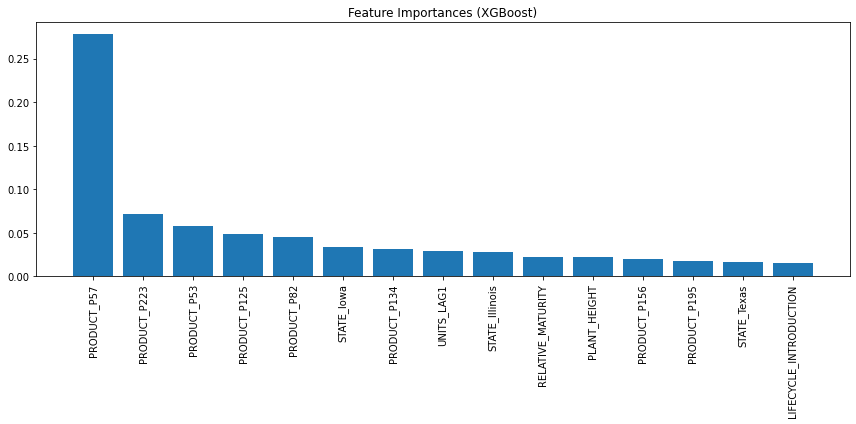

In [153]:
# 1. Extract trained XGBoost model from pipeline
xgb_model = best_model.named_steps['regressor']

# 2. Get all feature names after transformation
def get_feature_names(preprocessor):
    output_features = []
    # Get names from categorical transformer
    cat_transformer = preprocessor.named_transformers_['cat']
    encoder = cat_transformer.named_steps['encoder']
    cat_feature_names = encoder.get_feature_names_out(cat_cols)
    output_features.extend(cat_feature_names)
    # Get names from numeric transformer (these are just column names)
    output_features.extend(binary_cols + ordinal_cols + numeric_cols)
    return output_features

feature_names = get_feature_names(best_model.named_steps['preprocessor'])

# 3. Plot feature importances
importances = xgb_model.feature_importances_
indices = np.argsort(importances)[::-1]
sorted_names = [feature_names[i] for i in indices]

plt.figure(figsize=(12, 6))
N = 15
plt.bar(range(N), importances[indices][:N], align='center')
plt.xticks(range(N), sorted_names[:N], rotation=90)
plt.title('Feature Importances (XGBoost)')
plt.tight_layout()

In [ ]:
# SHAP interpretation
import shap

# Get preprocessor and trained XGBoost model
preprocessor = best_model.named_steps['preprocessor']
xgb_model = best_model.named_steps['regressor']

# Transform your test set (X_test)
X_trans = preprocessor.transform(X_test)  # Make sure X_test uses only columns in all_features!
feature_names = get_feature_names(preprocessor)

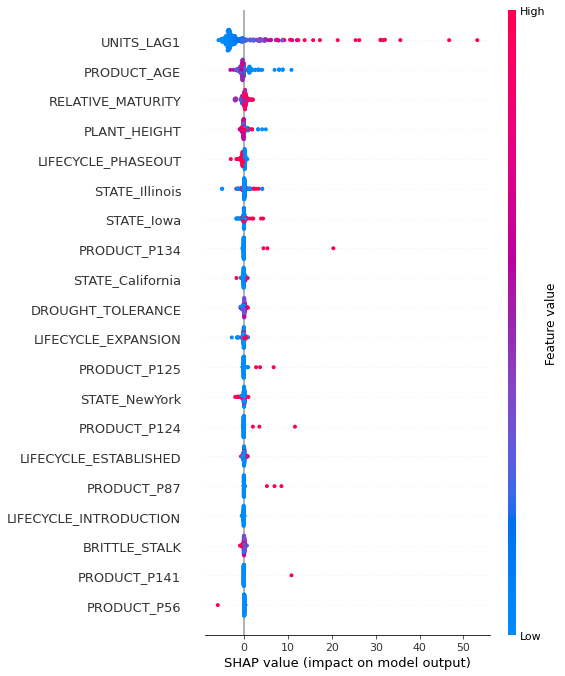

In [155]:
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_trans)
shap.summary_plot(shap_values, features=X_trans, feature_names=feature_names)
#shap.plots.waterfall(shap_df, max_display=15)


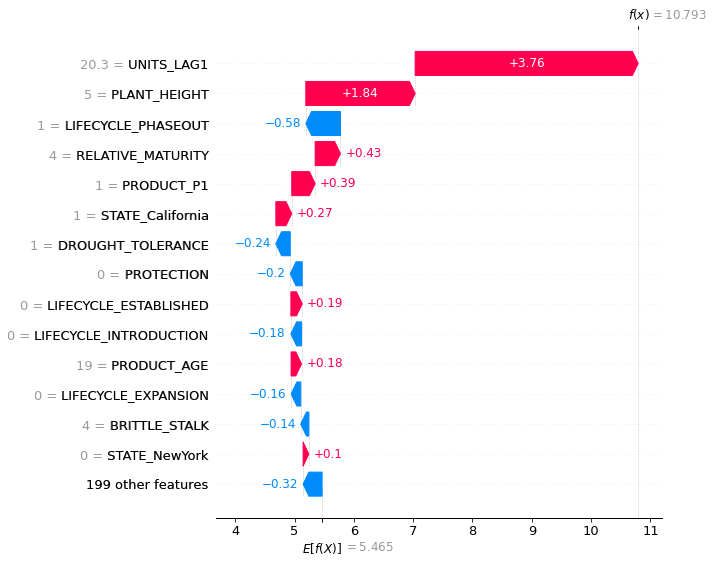

In [ ]:
# SHAP local waterfall
X_trans_df = pd.DataFrame(X_trans, columns=feature_names)
shap_values = explainer(X_trans_df)
shap.plots.waterfall(shap_values[0], max_display=15)